#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/1)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://api.semanticscholar.org/CorpusID:216056360).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


## Setup


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity('ERROR')

import tensorflow_datasets as tfds
import tensorflow_hub as hub

try:
  from google.colab import data_table
  def display_df(df):
    return data_table.DataTable(df, include_index=False)
except ModuleNotFoundError:
  # If google-colab is not available, just display the raw DataFrame
  def display_df(df):
    return df

2023-12-08 12:48:27.515971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 12:48:27.516018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 12:48:27.517510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

2023-12-08 12:48:30.788390: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.
2023-12-08 12:48:30.951318: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


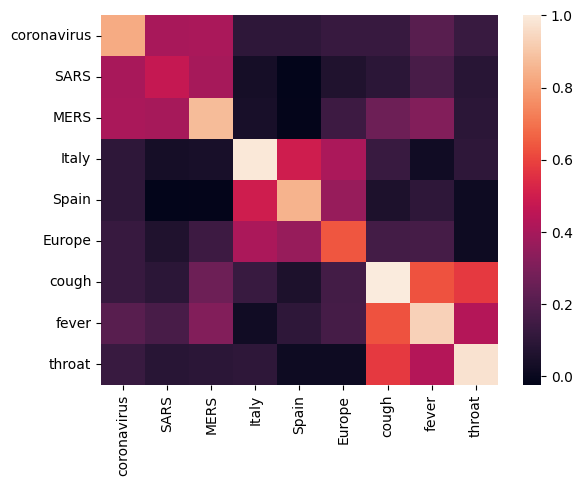

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)


with tf.Graph().as_default():
  # Load the module
  query_input = tf.placeholder(tf.string)
  module = hub.Module('https://tfhub.dev/tensorflow/cord-19/swivel-128d/1')
  embeddings = module(query_input)

  with tf.train.MonitoredTrainingSession() as sess:

    # Generate embeddings for some terms
    queries = [
        # Related viruses
        "coronavirus", "SARS", "MERS",
        # Regions
        "Italy", "Spain", "Europe",
        # Symptoms
        "cough", "fever", "throat"
    ]

    features = sess.run(embeddings, feed_dict={query_input: queries})
    plot_correlation(queries, features)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
#@title Set up the dataset from TFDS

class Dataset:
  """Build a dataset from a TFDS dataset."""
  def __init__(self, tfds_name, feature_name, label_name):
    self.dataset_builder = tfds.builder(tfds_name)
    self.dataset_builder.download_and_prepare()
    self.feature_name = feature_name
    self.label_name = label_name
  
  def get_data(self, for_eval):
    splits = THE_DATASET.dataset_builder.info.splits
    if tfds.Split.TEST in splits:
      split = tfds.Split.TEST if for_eval else tfds.Split.TRAIN
    else:
      SPLIT_PERCENT = 80
      split = "train[{}%:]".format(SPLIT_PERCENT) if for_eval else "train[:{}%]".format(SPLIT_PERCENT)
    return self.dataset_builder.as_dataset(split=split)

  def num_classes(self):
    return self.dataset_builder.info.features[self.label_name].num_classes

  def class_names(self):
    return self.dataset_builder.info.features[self.label_name].names

  def preprocess_fn(self, data):
    return data[self.feature_name], data[self.label_name]

  def example_fn(self, data):
    feature, label = self.preprocess_fn(data)
    return {'feature': feature, 'label': label}, label


def get_example_data(dataset, num_examples, **data_kw):
  """Show example data"""
  with tf.Session() as sess:
    batched_ds = dataset.get_data(**data_kw).take(num_examples).map(dataset.preprocess_fn).batch(num_examples)
    it = tf.data.make_one_shot_iterator(batched_ds).get_next()
    data = sess.run(it)
  return data


TFDS_NAME = 'scicite' #@param {type: "string"}
TEXT_FEATURE_NAME = 'string' #@param {type: "string"}
LABEL_NAME = 'label' #@param {type: "string"}
THE_DATASET = Dataset(TFDS_NAME, TEXT_FEATURE_NAME, LABEL_NAME)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES = 20  #@param {type:"integer"}
data = get_example_data(THE_DATASET, NUM_EXAMPLES, for_eval=False)
display_df(
    pd.DataFrame({
        TEXT_FEATURE_NAME: [ex.decode('utf8') for ex in data[0]],
        LABEL_NAME: [THE_DATASET.class_names()[x] for x in data[1]]
    }))

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using an Estimator. Let's set up the input_fns to read the dataset into the model

In [6]:
def preprocessed_input_fn(for_eval):
  data = THE_DATASET.get_data(for_eval=for_eval)
  data = data.map(THE_DATASET.example_fn, num_parallel_calls=1)
  return data


def input_fn_train(params):
  data = preprocessed_input_fn(for_eval=False)
  data = data.repeat(None)
  data = data.shuffle(1024)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_eval(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.repeat(1)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_predict(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.batch(batch_size=params['batch_size'])
  return data

Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [7]:
def model_fn(features, labels, mode, params):
  # Embed the text
  embed = hub.Module(params['module_name'], trainable=params['trainable_module'])
  embeddings = embed(features['feature'])

  # Add a linear layer on top
  logits = tf.layers.dense(
      embeddings, units=THE_DATASET.num_classes(), activation=None)
  predictions = tf.argmax(input=logits, axis=1)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'logits': logits,
            'predictions': predictions,
            'features': features['feature'],
            'labels': features['label']
        })
  
  # Set up a multi-class classification head
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
  loss = tf.reduce_mean(loss)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    precision = tf.metrics.precision(labels=labels, predictions=predictions)
    recall = tf.metrics.recall(labels=labels, predictions=predictions)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        })


In [8]:
#@title Hyperparmeters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/1'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}
STEPS =   8000#@param {type: "integer"}
EVAL_EVERY = 200  #@param {type: "integer"}
BATCH_SIZE = 10  #@param {type: "integer"}
LEARNING_RATE = 0.01  #@param {type: "number"}

params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'module_name': EMBEDDING,
    'trainable_module': TRAINABLE_MODULE
}

## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [9]:
estimator = tf.estimator.Estimator(functools.partial(model_fn, params=params))
metrics = []

for step in range(0, STEPS, EVAL_EVERY):
  estimator.train(input_fn=functools.partial(input_fn_train, params=params), steps=EVAL_EVERY)
  step_metrics = estimator.evaluate(input_fn=functools.partial(input_fn_eval, params=params))
  print('Global step {}: loss {:.3f}, accuracy {:.3f}'.format(step, step_metrics['loss'], step_metrics['accuracy']))
  metrics.append(step_metrics)

2023-12-08 12:48:33.010439: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_22340/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


2023-12-08 12:48:34.207730: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 0: loss 0.796, accuracy 0.676


2023-12-08 12:48:35.340060: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:36.577532: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 200: loss 0.711, accuracy 0.723


2023-12-08 12:48:37.442000: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:38.595031: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 400: loss 0.656, accuracy 0.746


2023-12-08 12:48:39.423699: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:40.561417: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 600: loss 0.637, accuracy 0.759


2023-12-08 12:48:41.356471: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:42.537650: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 800: loss 0.619, accuracy 0.764


2023-12-08 12:48:43.355380: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:44.476080: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1000: loss 0.609, accuracy 0.766


2023-12-08 12:48:45.316227: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:46.504330: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1200: loss 0.598, accuracy 0.771


2023-12-08 12:48:47.340830: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:48.466646: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1400: loss 0.593, accuracy 0.767


2023-12-08 12:48:49.286918: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:50.457809: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1600: loss 0.595, accuracy 0.758


2023-12-08 12:48:51.249988: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:52.446986: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1800: loss 0.571, accuracy 0.779


2023-12-08 12:48:53.274230: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:54.434837: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2000: loss 0.568, accuracy 0.783


2023-12-08 12:48:55.299387: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:56.475862: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2200: loss 0.571, accuracy 0.776


2023-12-08 12:48:57.269084: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:48:58.397282: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2400: loss 0.566, accuracy 0.778


2023-12-08 12:48:59.235274: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:00.356780: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2600: loss 0.557, accuracy 0.784


2023-12-08 12:49:01.218506: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:02.386721: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2800: loss 0.563, accuracy 0.778


2023-12-08 12:49:03.199324: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:04.318687: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3000: loss 0.550, accuracy 0.786


2023-12-08 12:49:05.110495: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:06.261538: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3200: loss 0.562, accuracy 0.776


2023-12-08 12:49:07.171228: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:08.667504: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3400: loss 0.552, accuracy 0.781


2023-12-08 12:49:09.484246: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:10.600743: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3600: loss 0.550, accuracy 0.783


2023-12-08 12:49:11.377686: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:12.537445: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3800: loss 0.552, accuracy 0.778


2023-12-08 12:49:13.352478: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:14.508544: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4000: loss 0.542, accuracy 0.790


2023-12-08 12:49:15.292799: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:16.477257: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4200: loss 0.548, accuracy 0.782


2023-12-08 12:49:17.268025: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:18.402629: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4400: loss 0.543, accuracy 0.787


2023-12-08 12:49:19.248701: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:20.367887: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4600: loss 0.555, accuracy 0.776


2023-12-08 12:49:21.180510: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:22.369558: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4800: loss 0.547, accuracy 0.781


2023-12-08 12:49:23.181419: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:24.311083: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5000: loss 0.547, accuracy 0.781


2023-12-08 12:49:25.155068: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:26.331803: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5200: loss 0.545, accuracy 0.781


2023-12-08 12:49:27.130941: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:28.297888: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5400: loss 0.537, accuracy 0.791


2023-12-08 12:49:29.083932: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:30.202671: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5600: loss 0.537, accuracy 0.792


2023-12-08 12:49:30.978953: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:32.138923: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5800: loss 0.539, accuracy 0.783


2023-12-08 12:49:32.917647: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:34.096059: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6000: loss 0.547, accuracy 0.781


2023-12-08 12:49:34.883889: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:36.023115: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6200: loss 0.543, accuracy 0.780


2023-12-08 12:49:36.813851: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:37.968537: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6400: loss 0.552, accuracy 0.779


2023-12-08 12:49:38.770655: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:39.883148: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6600: loss 0.539, accuracy 0.789


2023-12-08 12:49:40.754775: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:42.177644: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6800: loss 0.544, accuracy 0.781


2023-12-08 12:49:42.983284: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:44.163402: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7000: loss 0.549, accuracy 0.776


2023-12-08 12:49:44.950029: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:46.082210: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7200: loss 0.541, accuracy 0.782


2023-12-08 12:49:46.875834: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:48.020500: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7400: loss 0.537, accuracy 0.788


2023-12-08 12:49:48.796410: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:49.917295: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7600: loss 0.536, accuracy 0.784


2023-12-08 12:49:50.722712: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2023-12-08 12:49:53.921858: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7800: loss 0.535, accuracy 0.788


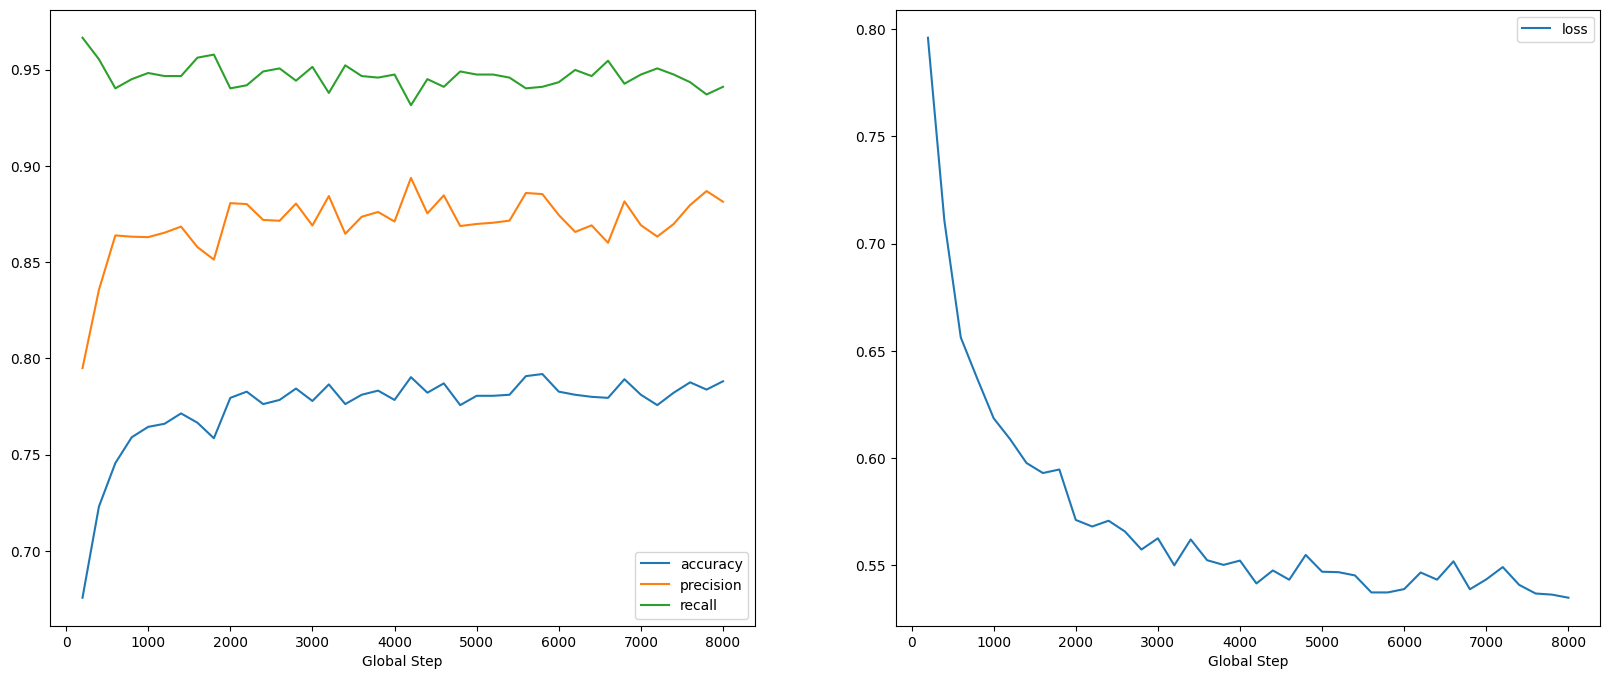

In [10]:
global_steps = [x['global_step'] for x in metrics]
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

for axes_index, metric_names in enumerate([['accuracy', 'precision', 'recall'],
                                            ['loss']]):
  for metric_name in metric_names:
    axes[axes_index].plot(global_steps, [x[metric_name] for x in metrics], label=metric_name)
  axes[axes_index].legend()
  axes[axes_index].set_xlabel("Global Step")

We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
predictions = estimator.predict(functools.partial(input_fn_predict, params))

In [12]:
first_10_predictions = list(itertools.islice(predictions, 10))

display_df(
  pd.DataFrame({
      TEXT_FEATURE_NAME: [pred['features'].decode('utf8') for pred in first_10_predictions],
      LABEL_NAME: [THE_DATASET.class_names()[pred['labels']] for pred in first_10_predictions],
      'prediction': [THE_DATASET.class_names()[pred['predictions']] for pred in first_10_predictions]
  }))

2023-12-08 12:49:55.139497: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_22340/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,result
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background


We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/1
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/1/tensorboard/full_projector_config.json)